In [1]:
using HDF5

In [2]:
function read_omega_and_decay_rates(file, γᵢ)

    h5open(file,"r") do fid
        γ_group = open_group(fid, "gamma_"*γᵢ) # create coupling group   

        omega = read(γ_group["omega"])
        relaxation = read(γ_group["gamma_relaxation"])
        de_phasing = read(γ_group["gamma_de_phasing"])
        #exitation = read(γ_group["gamma_exitation"])
        de_polarisation = read(γ_group["gamma_de_polarisation"])

        return(omega, relaxation, de_phasing, de_polarisation)
        
    end
end

read_omega_and_decay_rates (generic function with 1 method)

In [3]:
file = "../TESTS/POP_LME_5_random_trn4_tst20_2024-Jan-16_at_16-36.h5"
gammas = ["0.079477", "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

8-element Vector{String}:
 "0.079477"
 "0.25133"
 "0.79477"
 "2.5133"
 "7.9477"
 "25.133"
 "79.477"
 "251.33"

In [4]:
γᵢ = "0.079477"

"0.079477"

In [5]:
w, r, ϕ, p = read_omega_and_decay_rates(file, "0.079477")

(25.12611363705183, 0.07945784832167743, 7.459590438943091e-13, 5.4309948711488515e-6)

In [6]:
H = [ w   0
      0   0. ]

J₁ = [ 0   r
       0   0. ]

J₂ = ϕ * [ 1    0
           0   -1. ]

#J₃ = [ 0   0
#       e   0. ]

J₄ = p * [ 0    1
           1    0. ]

J₅ = p * [ 0   -im
           im   0  ]

J₆ = p * [ 1    0
           0   -1. ]

2×2 Matrix{Float64}:
 5.43099e-6   0.0
 0.0         -5.43099e-6

In [7]:
include("../LiPoSID.jl")

data_dir = "../DATA/"
dodeca_files = ["State_D"*string(n) for n=1:20];
df = dodeca_files[11]

ρₛ, tₛ = LiPoSID.get_rho_series(data_dir*df*"_2CUT_data.h5", γᵢ);

In [8]:
using QuantumOptics
basis = NLevelBasis(2)
using LinearAlgebra

ρᵗˢᵗ = [DenseOperator(basis,Hermitian(ρₜ)) for ρₜ in ρₛ]
tᵗˢᵗ = convert(Vector{Float64}, tₛ)

tˢⁱᵈ, ρˢⁱᵈ  = timeevolution.master(tᵗˢᵗ, ρᵗˢᵗ[1], DenseOperator(basis,H), 
            [ DenseOperator(basis,J₁), DenseOperator(basis,J₂),
             DenseOperator(basis,J₄), DenseOperator(basis,J₅), DenseOperator(basis,J₆)]);


In [9]:
bᵗˢᵗ = LiPoSID.bloch([ρₜ.data for ρₜ in ρˢⁱᵈ])

3×1256 Matrix{Float64}:
 -0.611892  -0.276278   0.127603  …   0.357358   0.63278    0.751716
 -0.53972   -0.767657  -0.805766     -0.663657  -0.409466  -0.0540703
 -0.572606  -0.572408  -0.572209     -0.342478  -0.342308  -0.342139

In [10]:
bˢⁱᵈ = LiPoSID.bloch(ρₛ)

3×1256 Matrix{Float64}:
 -0.611892  -0.276424   0.126852  …   0.198099   0.281675  0.295641
 -0.53972   -0.766762  -0.803873     -0.22436   -0.101192  0.0467592
 -0.572606  -0.570185  -0.56756       0.786993   0.787319  0.787629

In [11]:
function xyz(b)
    x = b[1, :]
    y = b[2, :]
    z = b[3, :]
    return x,y,z
end



xyz (generic function with 1 method)

In [16]:
using PyPlot

function sphere(r, C)   # r: radius; C: center [cx,cy,cz]
    n = 100
    u = range(-π, π; length = n)
    v = range(0, π; length = n)
    x = C[1] .+ r*cos.(u) * sin.(v)'
    y = C[2] .+ r*sin.(u) * sin.(v)'
    z = C[3] .+ r*ones(n) * cos.(v)'
    return x, y, z
end

function plot_sphere(r, C)
    x, y, z = sphere(r, C)
    fig = figure("3D sphere", figsize=(12, 12))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, z, alpha=0.4, cmap="plasma", edgecolor="none")
    ax.set_axis_off()
    show() 
end



sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [20]:
x, y, z = sphere(1, [0, 0, 0])
fig = figure("3D sphere", figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z, alpha=0.4, cmap="plasma", edgecolor="none")
ax.set_axis_off()
fig.show()

In [21]:
plot(xyz(bˢⁱᵈ), label="POP-LME", linewidth=1)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/zah/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("Axes3D.plot() missing 1 required positional argument: 'ys'")
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 2757, in plot
    return gca().plot(


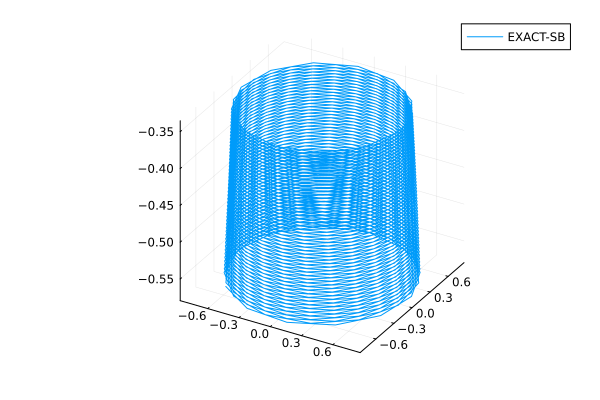

In [20]:
plot(xyz(bᵗˢᵗ), label = "EXACT-SB", linewidth=1)